In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import math
import statsmodels.api as sm
import pylab
%matplotlib inline

In [81]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')

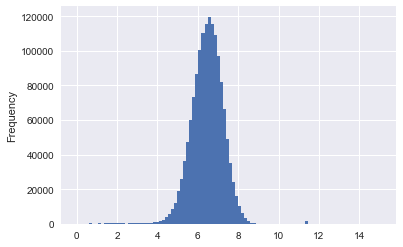

In [82]:
df_train['log_trip_duration'] = np.log(df_train['trip_duration'].values)
df_train['log_trip_duration'].plot.hist(bins=100)

In [83]:
df_train['trip_duration'].max()/3600

979.52277777777783

In [84]:
df_train['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [85]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_train.loc[:, 'pickup_date'] = df_train['pickup_datetime'].dt.date
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.date
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)
df_train['store_and_fwd_flag'] = 1 * (df_train.store_and_fwd_flag.values == 'Y')
df_test['store_and_fwd_flag'] = 1 * (df_test.store_and_fwd_flag.values == 'Y')
df_train['check_trip_duration'] = (df_train['dropoff_datetime'] - df_train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = df_train[np.abs(df_train['check_trip_duration'].values  - df_train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [86]:
df_train.loc[:, 'pickup_weekday'] = df_train['pickup_datetime'].dt.weekday
df_train.loc[:, 'pickup_hour_weekofyear'] = df_train['pickup_datetime'].dt.weekofyear
df_train.loc[:, 'pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train.loc[:, 'pickup_minute'] = df_train['pickup_datetime'].dt.minute
df_train.loc[:, 'pickup_dt'] = (df_train['pickup_datetime'] - df_train['pickup_datetime'].min()).dt.total_seconds()
df_train.loc[:, 'pickup_week_hour'] = df_train['pickup_weekday'] * 24 + df_train['pickup_hour']
df_train['Month'] = df_train['pickup_datetime'].dt.month
df_test['Month'] = df_test['pickup_datetime'].dt.month

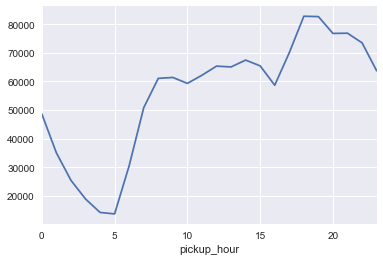

In [105]:
df_train.groupby(['pickup_hour']).size().plot.line()
#number of trips each hour, peaking around dinner time

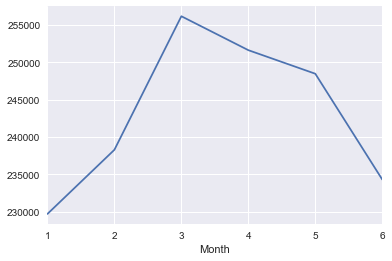

In [88]:
df_train.groupby(['Month']).size().plot.line()
#strange that data is only 6 months of the year???

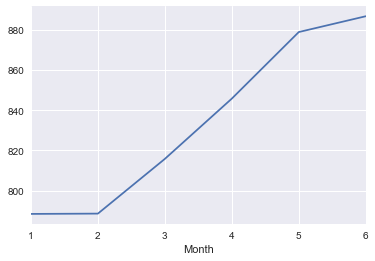

In [110]:
df_train.groupby(['Month'])['trip_duration'].mean().plot.line()
#do the trip times increase as a result of summer?

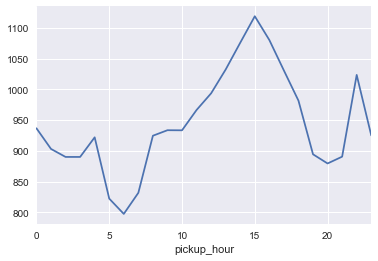

In [90]:
df_train.groupby(['pickup_hour'])['trip_duration'].mean().plot.line()
#do the trip times increase as a result of rush hour? not really it seems there is a big peak at 3pm
#lulls in ridership in early morning and around 8pm

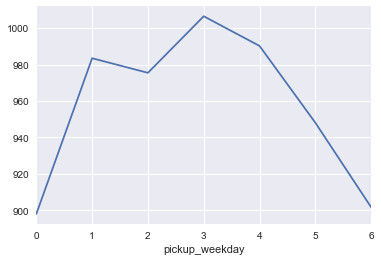

In [91]:
df_train.groupby(['pickup_weekday'])['trip_duration'].mean().plot.line()
#peak traffic on wednesdays

In [92]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,pickup_date,check_trip_duration,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,Month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,6.120297,2016-03-14,455.0,0,11,17,24,6369878.0,17,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,6.496775,2016-06-12,663.0,6,23,0,43,14085798.0,144,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,7.661056,2016-01-19,2124.0,1,3,11,35,1596907.0,35,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,6.061457,2016-04-06,429.0,2,14,19,32,8364734.0,67,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,6.075346,2016-03-26,435.0,5,12,13,30,7392638.0,133,3


In [93]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 21 columns):
id                        1458644 non-null object
vendor_id                 1458644 non-null int64
pickup_datetime           1458644 non-null datetime64[ns]
dropoff_datetime          1458644 non-null datetime64[ns]
passenger_count           1458644 non-null int64
pickup_longitude          1458644 non-null float64
pickup_latitude           1458644 non-null float64
dropoff_longitude         1458644 non-null float64
dropoff_latitude          1458644 non-null float64
store_and_fwd_flag        1458644 non-null int64
trip_duration             1458644 non-null int64
log_trip_duration         1458644 non-null float64
pickup_date               1458644 non-null object
check_trip_duration       1458644 non-null float64
pickup_weekday            1458644 non-null int64
pickup_hour_weekofyear    1458644 non-null int64
pickup_hour               1458644 non-null int64
pickup_minute         

In [99]:
df_train['passenger_count'].describe()

count    1.330033e+06
mean     1.311557e+00
std      6.574672e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.000000e+00
Name: passenger_count, dtype: float64

In [100]:
df_train = df_train[df_train['passenger_count']<5]

In [101]:
df_train = df_train[df_train['trip_duration']<6000]
df_train['trip_duration'].describe()

count    1.330033e+06
mean     8.344028e+02
std      6.490852e+02
min      1.000000e+00
25%      3.960000e+02
50%      6.610000e+02
75%      1.072000e+03
max      5.999000e+03
Name: trip_duration, dtype: float64

Explore the following using hypothesis testing or correlations:
 1. Is there a statistical difference between the taxi vendors trip durations?
 - trip duration vs passenger count
 - trip duration vs time of year (seasonal, i.e. summer/winter)
 - impact of rush hour on trip duration
 - demonstrate the trip durations to airports is related to the pickup distance from the airport
 - trip duration vs total distance (need to import the OCRM data)
 
 
 Cleaning Data:
 - remove the super long trips: set limit to no more than 100minutes
 - remove the trips with >5 passengers : removed all trips with passengers >5
 - remove trips that have zero distance and greater than 5 minutes  <<<don't know how to do yet>>>

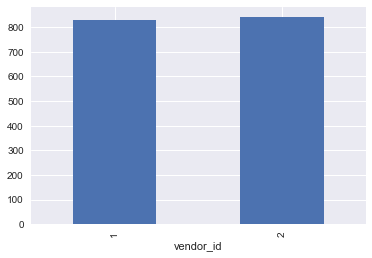

In [97]:
df_train.groupby(['vendor_id'])['trip_duration'].mean().plot.bar()

In [125]:
vendor1_df = df_train[df_train['vendor_id']==1]
vendor2_df = df_train[df_train['vendor_id']==2]

trip = df_train.as_matrix(columns=['trip_duration'])

vendor1_trip = vendor1_df.as_matrix(columns=['trip_duration'])
vendor2_trip = vendor2_df.as_matrix(columns=['trip_duration'])

mu_vendor1 = np.mean(vendor1_trip)
sig_vendor1 = np.std(vendor1_trip)

mu_vendor2 = np.mean(vendor2_trip)
sig_vendor2 = np.std(vendor2_trip)

mu_trip = np.mean(trip)
sig_trip = np.std(trip)

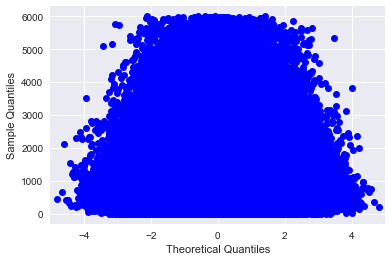

In [126]:
sm.qqplot(trip)
pylab.show()

In [118]:
stats.mstats.normaltest(trip)

NormaltestResult(statistic=masked_array(data = [601718.7160193013],
             mask = [False],
       fill_value = 1e+20)
, pvalue=array([ 0.]))

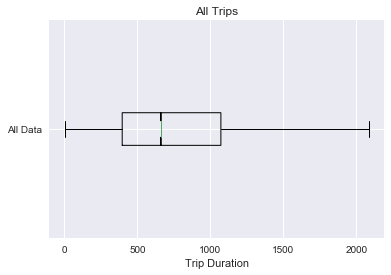

In [127]:
plt.figure()
plt.boxplot([trip],1 ,'rs',0, labels=['All Data'],showfliers=False)
plt.xlabel('Trip Duration')
plt.title('All Trips')
None

In [131]:
df_train.groupby(['vendor_id'])['id'].count()
#huge sample, probably will use z-stat assuming it is representative of the population standard deviation

vendor_id
1    677637
2    652396
Name: id, dtype: int64

In [139]:
def get_z(sample1, sample2):
    z = (np.mean(sample1) - np.mean(sample2)) / math.sqrt(np.std(sample1)**2/len(sample1)+np.std(sample2)**2/len(sample2))
    return z


def get_t(sample, null_hypo):
    t = (np.mean(sample) - null_hypo) / (np.std(sample) / math.sqrt(len(sample)))
    return t

In [141]:
z = get_z(vendor1_trip, vendor2_trip)
print('Z statastic:', z)
#makes it very unlikely that the means are statistically inequal, null hypothesis will not be rejected

Z statastic: -10.1915132951
